In [168]:
plt.rcParams['figure.figsize'] = [15, 12]

# Tabela 1

In [67]:
import sys
import logging
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import count, max
import findspark 
import math
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
import pandas as pd
import pyspark
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, max, mean
from pyspark.sql import functions as F 
import seaborn as sns
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

In [68]:
def get_team(lat1, lon1, stopsT):
    distS = stopsT.copy()
    distS['dist'] = distS.apply (lambda row: calculateDistance(lat1, lon1, row['lat'], row['lon']), axis=1) 
    return distS[distS.dist == distS.dist.min()].iat[0,0]
def calculateDistance(lat1, lon1, lat2, lon2):
        earthR = 6371e3
    
        fi1 = lat1 * math.pi / 180
        fi2 = lat2 * math.pi / 180
        deltaFi = (lat2 - lat1) * math.pi / 180
        lambda_ = (lon2 - lon1) * math.pi / 180
        haversine = math.pow(math.sin(deltaFi / 2), 2) + math.cos(fi1) * math.cos(fi2) * math.pow(math.sin(lambda_ / 2), 2)
        c = 2 * math.atan2(math.sqrt(haversine), math.sqrt(1 - haversine))
        return earthR * c
    
calcDistPS = udf(calculateDistance, DoubleType())

In [3]:
findspark.init() 
sc = SparkContext("local[2]", "First App")

22/01/22 15:41:19 WARN Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 192.168.137.164 instead (on interface ens3)
22/01/22 15:41:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/22 15:41:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [138]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)
trams = hive_context.table("trams")
trams = trams.filter(trams.day == "2022-01-12")
trams = trams.withColumn("time", trams["time"].cast("double"))

/home/vagrant/.local/lib/python3.7/site-packages/pyspark/sql/context.py:604: FutureWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  FutureWarning


In [ ]:
import happybase

conn = happybase.Connection('localhost')
conn.open()
tramsInfo = conn.table('tramsInfo') 

In [139]:
stops = hive_context.table("stops")

In [140]:
w = Window().partitionBy("lines", "vehiclenumber", "brigade").orderBy(col("lines"), col("vehiclenumber"), col("time"))
# w = Window().partitionBy("lines").orderBy(col("lines"), col("vehiclenumber"), col("time"))
tramsPrev = trams.select("*", lag("lat", default = 0).over(w).alias("latPrev")).na.drop()
tramsPrev = tramsPrev.select("*", lag("lon", default = 0).over(w).alias("lonPrev")).na.drop()
tramsPrev = tramsPrev.select("*", lag("time", default = 0).over(w).alias("timePrev")).na.drop()
tramsPrev = tramsPrev.filter(tramsPrev.timePrev != 0)

In [141]:
tramsMoving = tramsPrev.withColumn("distance", calcDistPS("lat", "lon", "latPrev", "lonPrev"))
tramsMoving = tramsMoving.withColumn("timeDiff", (tramsMoving.time - tramsMoving.timePrev)/1000)
tramsMoving = tramsMoving.withColumn("velocity", tramsMoving.distance / tramsMoving.timeDiff)

In [142]:
stopsAgg = stops.groupBy("nazwa_zespolu").agg(mean("szer_geo").alias('lat_stops'), 
                                              mean("dlug_geo").alias('lon_stops'),
                                             F.min("zespol").alias('zespol'))
stopsAggTram = stopsAgg.filter((stopsAgg.lat_stops > 52.15) & (stopsAgg.lat_stops < 52.35) & (stopsAgg.lon_stops > 20.9) & (stopsAgg.lon_stops < 21.1))

In [143]:
joined = tramsMoving.crossJoin(stopsAggTram)

In [144]:
joined = joined.withColumn("distance_to_team", calcDistPS("lat", "lon", "lat_stops", "lon_stops"))
joined_min = joined.groupBy("lines", "lon", "lat", "vehiclenumber", "brigade", "time", "day").agg(F.min("distance_to_team").alias("distance_to_team"))
joined_names = joined.select(joined.lines, joined.lon, joined.lat, joined.vehiclenumber, joined.brigade,
                             joined.time, joined.day, 
                             joined.nazwa_zespolu, joined.distance_to_team, joined.velocity, 
                             joined.timeDiff, joined.zespol, joined.distance)
cond = [joined_min.lines == joined_names.lines, joined_min.lon == joined_names.lon, joined_min.lat == joined_names.lat, 
        joined_min.vehiclenumber == joined_names.vehiclenumber, joined_min.brigade == joined_names.brigade,
        joined_min.time == joined_names.time, joined_min.day == joined_names.day, joined_min.distance_to_team == joined_names.distance_to_team]
joined_final = joined_min.join(joined_names, cond, "left")

In [145]:
joined_final_Pd = joined_final.toPandas()

22/01/22 16:32:39 WARN ExtractPythonUDFFromJoinCondition: The join condition:isnotnull(calculateDistance(lat#1650, lon#1649, lat_stops#1559, lon_stops#1561)) of the join plan contains PythonUDF only, it will be moved out and the join plan will be turned to cross join.


In [ ]:
cols = {
    "infoTram": ["vehiclenumber","brigade"],
    "infoTeam": ["zespol","nazwa_zespolu"],
    "stats": ["velocity","lon","lat",
                         "distance", "time", "timeDiff"]
}

df = joined_final_Pd
df = df.loc[:,~df.columns.duplicated()]

table = conn.table("tramsStats")
for idx, row in df.iterrows():
    tmp = {}
    for family, family_cols in cols.items():
        for col in family_cols:
            colIns = col
            if row[col] != "'":
                ins = "'" + str(row[col]) + "'" 
            tmp["{}:{}".format(family, colIns)] = ins     
    table.put(str(row['lines']), tmp)

# Tabela 2

In [79]:
import sys
import logging
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import count, max
import findspark 
import math
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
import pandas as pd
import pyspark
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, max, mean
from pyspark.sql import functions as F 
import seaborn as sns
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
from pyspark.sql.functions import *

In [80]:
def get_team(lat1, lon1, stopsT):
    distS = stopsT.copy()
    distS['dist'] = distS.apply (lambda row: calculateDistance(lat1, lon1, row['lat'], row['lon']), axis=1) 
    return distS[distS.dist == distS.dist.min()].iat[0,0]
def calculateDistance(lat1, lon1, lat2, lon2):
        earthR = 6371e3
    
        fi1 = lat1 * math.pi / 180
        fi2 = lat2 * math.pi / 180
        deltaFi = (lat2 - lat1) * math.pi / 180
        lambda_ = (lon2 - lon1) * math.pi / 180
        haversine = math.pow(math.sin(deltaFi / 2), 2) + math.cos(fi1) * math.cos(fi2) * math.pow(math.sin(lambda_ / 2), 2)
        c = 2 * math.atan2(math.sqrt(haversine), math.sqrt(1 - haversine))
        return earthR * c
    
calcDistPS = udf(calculateDistance, DoubleType())

In [ ]:
findspark.init() 
sc = SparkContext("local[2]", "First App")

In [126]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)
trams = hive_context.table("trams")
trams = trams.filter(trams.day == "2022-01-12")
trams = trams.withColumn("time", trams["time"].cast("double"))

/home/vagrant/.local/lib/python3.7/site-packages/pyspark/sql/context.py:604: FutureWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  FutureWarning


In [ ]:
import happybase

conn = happybase.Connection('localhost',port=9090)
conn.open()
print(conn.tables())

In [127]:
w = Window().partitionBy("lines", "vehiclenumber", "brigade").orderBy(col("lines"), col("vehiclenumber"), col("time"))
# w = Window().partitionBy("lines").orderBy(col("lines"), col("vehiclenumber"), col("time"))
tramsPrev = trams.select("*", lag("lat", default = 0).over(w).alias("latPrev")).na.drop()
tramsPrev = tramsPrev.select("*", lag("lon", default = 0).over(w).alias("lonPrev")).na.drop()
tramsPrev = tramsPrev.select("*", lag("time", default = 0).over(w).alias("timePrev")).na.drop()
tramsPrev = tramsPrev.filter(tramsPrev.timePrev != 0)

In [128]:
tramsMoving = tramsPrev.withColumn("distance", calcDistPS("lat", "lon", "latPrev", "lonPrev"))
tramsMoving = tramsMoving.withColumn("timeDiff", (tramsMoving.time - tramsMoving.timePrev)/1000)
tramsMoving = tramsMoving.withColumn("velocity", tramsMoving.distance / tramsMoving.timeDiff)

In [129]:
tramsAgg = tramsMoving.groupBy("lines").agg(F.mean("velocity").alias('mean_velocity'),
                                           F.count("brigade").alias('number_of_brigades'),
                                           F.min("time").alias('min_time'),
                                           F.max("time").alias('max_time'),
                                           F.min("day").alias('day'))
tramsAgg = tramsAgg.withColumn("min_time", F.to_utc_timestamp(F.from_unixtime(F.col("min_time")/1000,'yyyy-MM-dd HH:mm:ss'),'EST'))\
        .withColumn("max_time", F.to_utc_timestamp(F.from_unixtime(F.col("max_time")/1000,
                                                                   'yyyy-MM-dd HH:mm:ss'),'EST'))

In [130]:
df = tramsAgg.toPandas()

In [ ]:
cols = {
    "stats": ["mean_velocity","number_of_brigades"],
    "dayStats": ["min_time","max_time", "day"]
}

df = df.loc[:,~df.columns.duplicated()]

table = conn.table("linesStats")
for idx, row in df.iterrows():
    tmp = {}
    for family, family_cols in cols.items():
        for col in family_cols:
            colIns = col
            if row[col] != "'":
                ins = "'" + str(row[col]) + "'" 
            tmp["{}:{}".format(family, colIns)] = ins     
    table.put(str(row['lines']), tmp)

# Wizualizacje

# Wizualizacja 1

In [146]:
df_hist = joined_final_Pd[(joined_final_Pd.velocity > 1) & (joined_final_Pd.velocity < 20) ]

In [147]:
df_hist = df_hist.loc[:,~df_hist.columns.duplicated()]

/home/vagrant/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


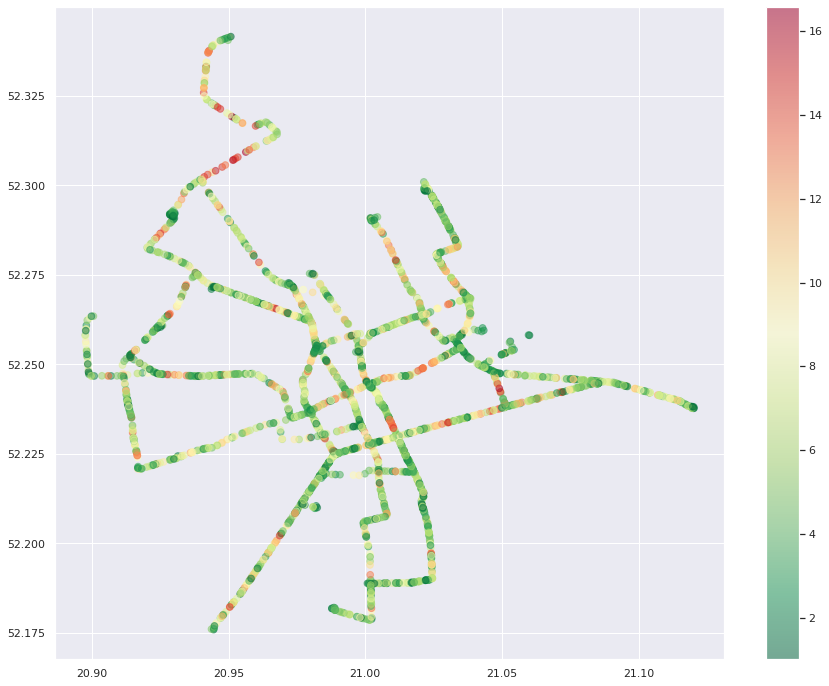

In [148]:
plt.scatter(df_hist['lon'],df_hist['lat'], c=df_hist['velocity'], s=45, alpha = 0.5, cmap="RdYlGn_r")
plt.colorbar()
plt.show()

# Wizualizacja 2

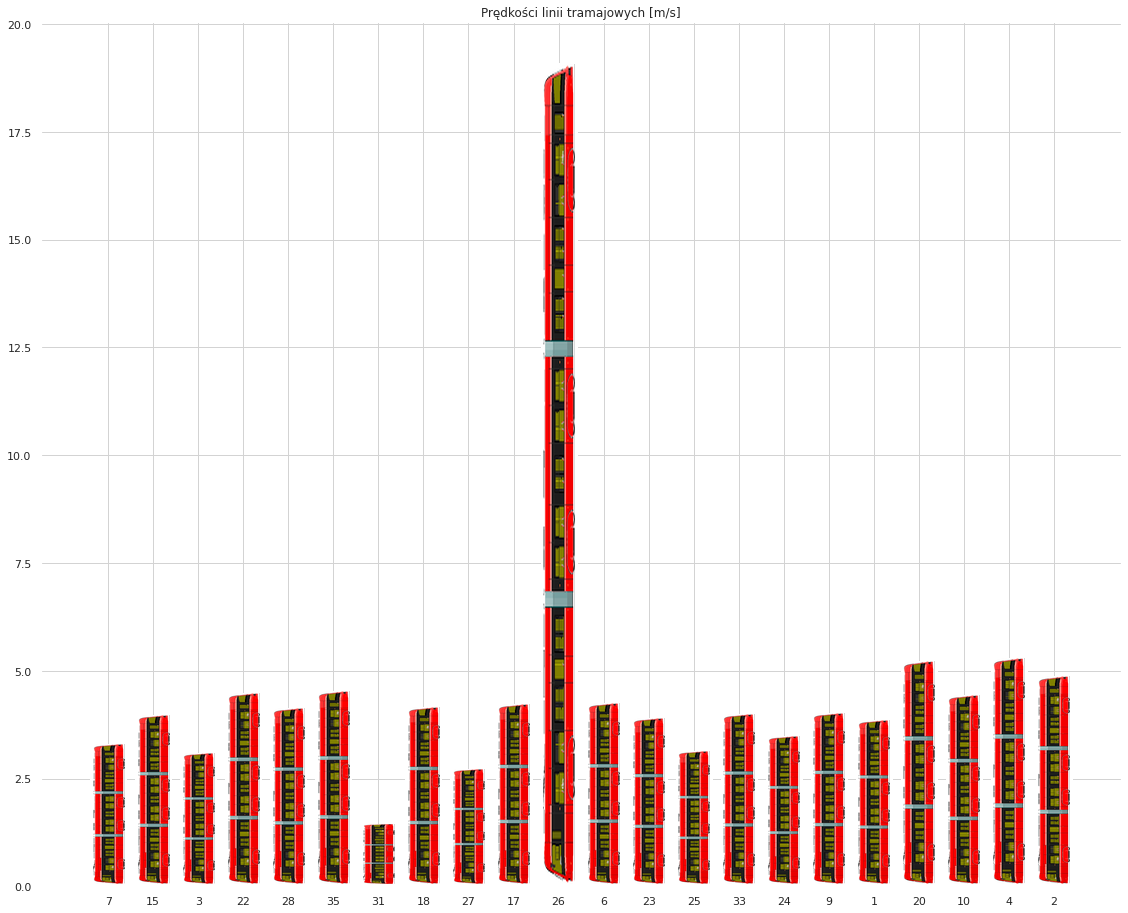

In [181]:
from PIL import Image
import requests

URL = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQSKRaBsJBV3AK70DOAeCIntOagLUn7_iuxKg&usqp=CAU"
im = Image.open(requests.get(URL, stream=True).raw)
im = im.convert('RGB')
im = im.transpose(Image.ROTATE_90)
w, h = im.size
im = im.crop((10, 0, w-10, h))
#im = im.resize((1,im.height), Image.ANTIALIAS)

plt.rcParams.update({"axes.grid" : True, "grid.color": "lightgray"})

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df['lines'], df['mean_velocity'], color = "white")
rects = ax.patches
i = 0
for rect, label in zip(rects, df.index.values):
    height = rect.get_height()
    im2 = im.resize((32,int(df['mean_velocity'][i] * 43)), Image.ANTIALIAS)
    
    fig.figimage(im2, i*45 + 93, 29)
    i+=1

font = {'weight' : 'normal',
        'size'   : 22}

ax.set_facecolor('white')

plt.title("Prędkości linii tramajowych [m/s]")

plt.rc('font', **font)

plt.show()

In [152]:
df2 = df_hist[df_hist.lines == '26']

Sprawdźmy dlaczego linia 26 jest tak szybka

/home/vagrant/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


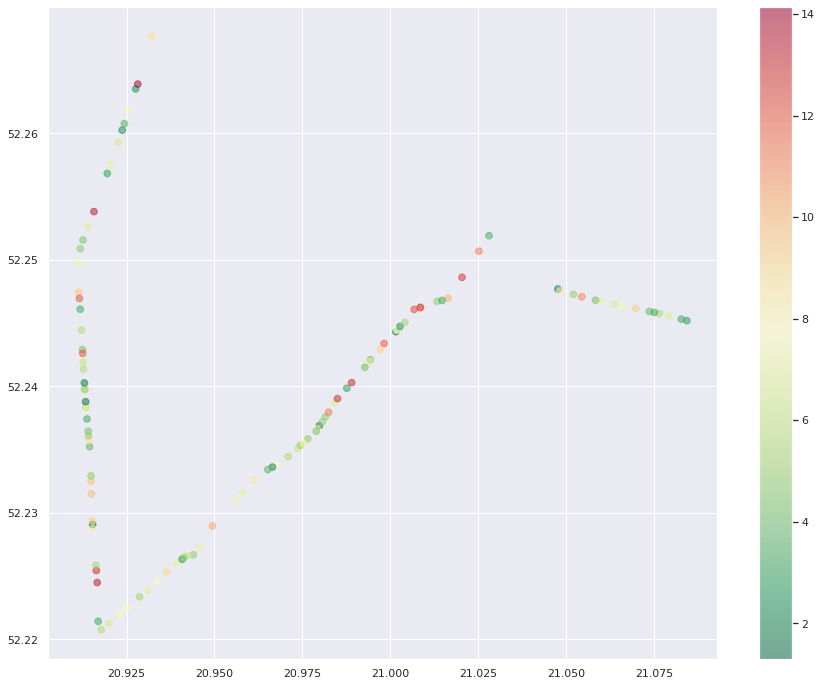

In [153]:
plt.scatter(df2['lon'],df2['lat'], c=df2['velocity'], s=45, alpha = 0.5, cmap="RdYlGn_r")
plt.colorbar()
plt.show()

# Wizualizacja 3

In [92]:
from datetime import datetime

In [93]:
wiz3Agg = tramsMoving.groupBy("time").agg(F.mean("velocity").alias('mean_velocity'))

In [94]:
wiz3AggPd = wiz3Agg.toPandas()

Usuwamy outliery

In [100]:
wiz3 = wiz3AggPd[wiz3AggPd.mean_velocity < 30].sort_values(by=['time'])

/home/vagrant/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


[[Text(1642622000000.0, 0, '2022-01-19 19:53:20'),
  Text(1642624000000.0, 0, '2022-01-19 20:26:40'),
  Text(1642626000000.0, 0, '2022-01-19 21:00:00'),
  Text(1642628000000.0, 0, '2022-01-19 21:33:20'),
  Text(1642630000000.0, 0, '2022-01-19 22:06:40'),
  Text(1642632000000.0, 0, '2022-01-19 22:40:00'),
  Text(1642634000000.0, 0, '2022-01-19 23:13:20'),
  Text(1642636000000.0, 0, '2022-01-19 23:46:40')]]

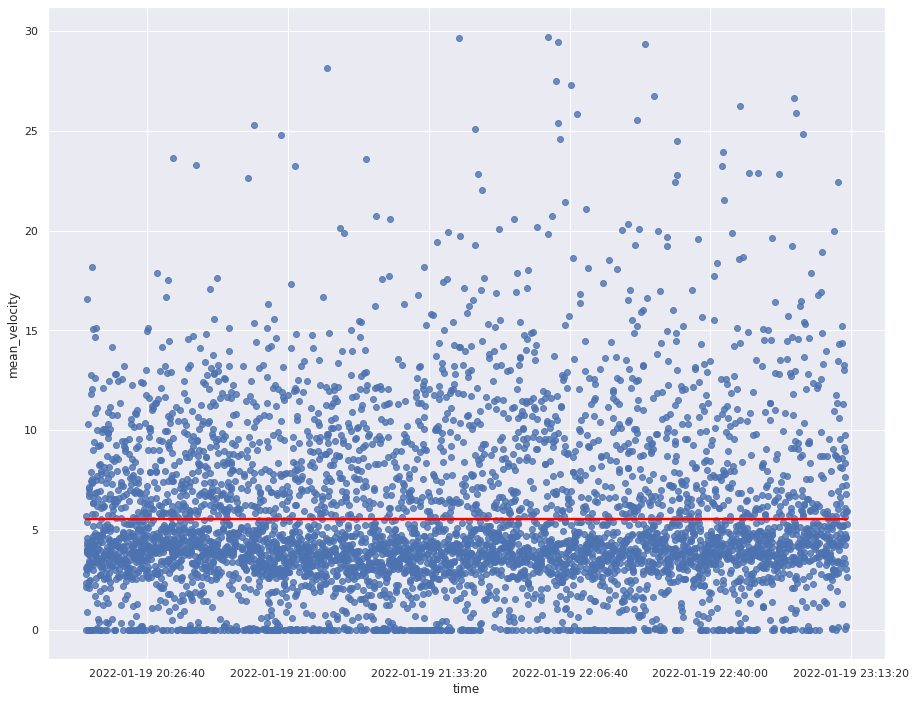

In [101]:
import seaborn as sns; sns.set_theme(color_codes=True)

ax = sns.regplot(x="time", y="mean_velocity", data=wiz3, line_kws={"color": "red"})
ax.set(xticklabels=[str(datetime.fromtimestamp(int(el/1000))) for el in ax.get_xticks()])
